In [9]:
import json
import pandas as pd

__video-creators.json__ contains video objects, including video id, creators name, hashtag list and so on. Description of fields can be found at APi page <br>
__follow-link.csv__ is a simple edge list 

In [10]:
videos = pd.read_json('../shared-folder-gald/data/video-creators.json')

# task:
* for each user in the follow-graph
    * collect liked videos 
    * keep only videos included in the video-creators file
    * create network of user_a---(liked videos by)--> user_b
    

1. list with usernames
2. api query for video id and creator username
3. remove non-liked
3. keep only the relevant videos (compare ids)


In [11]:
follows = pd.read_csv('../shared-folder-gald/data/follow-link.csv')

In [12]:
usernames = pd.unique(follows[['source', 'target']].values.ravel()).tolist()

In [13]:
len(usernames)

13867

In [14]:
import requests

In [17]:
with open("../shared-folder-gald/keys2.txt") as f:
    lines = f.readlines()
    client_key = lines[0].strip()
    client_secret = lines[1].strip()

In [18]:
def get_access_token(client_key, client_secret):
    # Endpoint URL
    endpoint_url = "https://open.tiktokapis.com/v2/oauth/token/"

    # Request headers
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
    }

    # Request body parameters
    data = {
        'client_key': client_key,
        'client_secret': client_secret,
        'grant_type': 'client_credentials',
    }

    # Make the POST request
    response = requests.post(endpoint_url, headers=headers, data=data)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse and print the response JSON
        response_json = response.json()
        return response_json['access_token']
    else:
        # If the request was not successful, print the error response JSON
        
        return response.json()

In [19]:
def get_liked_info(username, access_token,fields ="id, username" ):
    query_params = {"fields": fields}
    query_body = {"username": username}
    headers = {"Authorization": f"Bearer {access_token}"}
    
    endpoint = "https://open.tiktokapis.com/v2/research/user/liked_videos/"
    response = requests.post(endpoint, json=query_body, params=query_params, headers=headers)

    if response.status_code == 200:
        # Parse and extract information from the response
        return response.json().get("data", {})
    else:
        
        return {response.text}

In [20]:
access_token = get_access_token(client_key, client_secret)

In [21]:
liked_videos = []
for username in usernames[0:1000]:
    liked_videos.append(get_liked_info(username, access_token))

KeyboardInterrupt: 

In [43]:
combined = {}
for i, username in enumerate(usernames[0:1000]):
    combined[username] = liked_videos[i]

In [44]:
combined

{'designs_from_time': {},
 'cosmicsummit': {},
 'conspiracyhubog': {},
 'guildworld': {},
 'venetialamanna': {},
 'i_d': {},
 'texasbeeworks': {},
 'dcopperman': {},
 'healthyholistichomes': {},
 'maxlamanna': {},
 'thatcurlytopp': {},
 'zainab.slow.fashion': {},
 'politicsjoe': {},
 'tedtoks': {},
 'bbcnews': {'cursor': -1,
  'has_more': False,
  'user_liked_videos': [{'id': 7421594306210696481,
    'username': 'taliamaizels'},
   {'id': 7454572661281262880, 'username': 'bbcnews'},
   {'username': 'bbcnews', 'id': 7444593083552976161},
   {'id': 7381432178942414112, 'username': 'mahmood'},
   {'id': 7467351767571778858, 'username': 'msnbc'},
   {'id': 7422375191885516065, 'username': 'asherglean'},
   {'id': 7467078807531293984, 'username': 'bbcnews'},
   {'id': 7427533704760757537, 'username': 'employment_with_amy'},
   {'id': 7450533116449443104, 'username': 'bbcnews'},
   {'id': 7467084105746894113, 'username': 'bbcnews'},
   {'id': 7449352382959439136, 'username': 'tntsports'},
  

In [47]:
rows = []

for key, value in combined.items():
    if value and 'user_liked_videos' in value:  # Ensure key has data
        for video in value['user_liked_videos']:
            rows.append({
                'username': key,  # Dictionary key
                'id': video['id'],  # Video ID
                'creator': video['username']  # Video username
            })

# Create DataFrame
df = pd.DataFrame(rows)

# Display DataFrame
print(df)

           username                   id         creator
0           bbcnews  7421594306210696481    taliamaizels
1           bbcnews  7454572661281262880         bbcnews
2           bbcnews  7444593083552976161         bbcnews
3           bbcnews  7381432178942414112         mahmood
4           bbcnews  7467351767571778858           msnbc
..              ...                  ...             ...
614  straitnochase1  7470175184901704990  stella.alyssia
615  straitnochase1  7469029305545166123     bootybri_15
616  straitnochase1  7470168156607204639  stella.alyssia
617  straitnochase1  7469091593392344362     bootybri_15
618  straitnochase1  7469840932200828202       vicblends

[619 rows x 3 columns]


In [54]:
df.drop('id', axis=1)

,username,creator
0,bbcnews,taliamaizels
1,bbcnews,bbcnews
2,bbcnews,bbcnews
3,bbcnews,mahmood
4,bbcnews,msnbc
...,...,...
614,straitnochase1,stella.alyssia
615,straitnochase1,bootybri_15
616,straitnochase1,stella.alyssia
617,straitnochase1,bootybri_15


In [55]:
df = df.rename(columns={'username':'source', 'creator':'target'})
df = df.drop('id', axis=1)

In [56]:
import networkx as nx 

network = nx.from_pandas_edgelist(df)

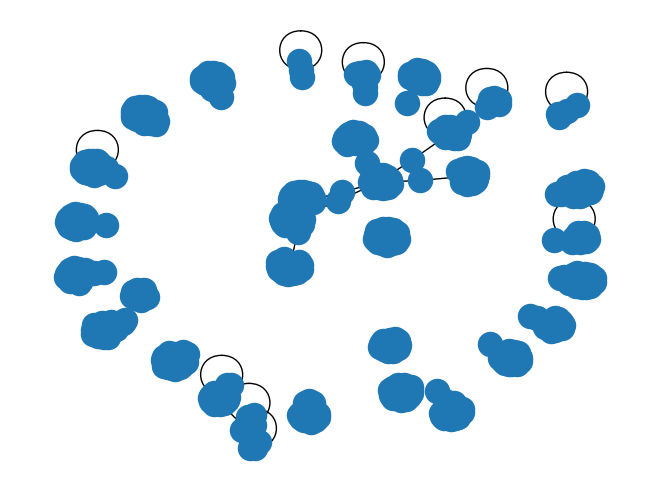

In [58]:
nx.draw(network, pos=nx.spring_layout(network))